# Likelihood-free Inference of Stable Distribution Parameters

## 1. Stable Distribution

Stable distributions, also known as $\alpha$-stable distributions and Lévy (alpha) stable distribution, are the distibutions with 4 parameters:
 * $\alpha \in (0, 2]$: stability parameter
 * $\beta \in [-1, 1]$: skewness parameter
 * $\mu \in [0, \infty)$: location parameter
 * $\sigma \in (-\infty, \infty)$: scale parameter

If two independent random variables follow stable distribution, then their linear combinations also have the same distribution up to scale and location parameters[1]. That is to say, if two random variables are generated using the same stability and skewness parameters, their linear combinations would have the same ($\alpha$ and $\beta$) parameters. Note that parameterization is different for multivariate stable distributions but in this work we are only interested in the univariate version. 

The distrubution has several attractive properties such as including infinite variance/skewness and having heavy tails, and therefore has been applied in many domains including statistics, finance, signal processing, etc[2]. Some special cases of stable distribution are are as follows:
 * If $\alpha=2$ and $\beta=0$, the distribution is Gaussian
 * If $\alpha=1$ and $\beta=0$, the distribution is Cauchy
 * Variance is undefined for $\alpha<2$ and mean is undefined for $\alpha\leq 1$ (Undefined meaning that the integrals for these moments are not finite)
 
Stable distributions have no general analytic expressions for the density, median, mode or entropy. On the other hand, it is possible to generate random variables given fixed parameters [2,3]. Therefore, ABC techniques are suitable to estimate the unknown parameters of stable distributions. In this notebook, we present how the estimation can be done using ELFI framework. A good list of alternative methods for the parameter estimation is given in [2].

## 2. Simulator and Data Generation

Below is the simulator implementation. The method takes 4 parameters of the stable distribution and generates random variates. We follow the algorithm outlined in [3].

In [12]:
import elfi
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import pickle

# http://www.ams.sunysb.edu/~yiyang/research/presentation/proof_simulate_stable_para_estimate.pdf
def stable_dist_rvs(alpha,beta,mu,sig,Ns=200,batch_size=1,random_state=None):
    '''
    generates random numbers from stable distribution
    Input
        alpha - stability parameter
        beta - skewness parameter
        c - scale parameter
        mu - location parameter
        N - number of random numbers
        Ns - number of samples in each batch
        batch_size
        random_state
    sigma in the last column of each batch
    '''
    assert(np.all(alpha!=1))
    N = batch_size
    Rs = np.zeros((batch_size,Ns))
    for i in range(len(alpha)):
        U = ss.uniform.rvs(size=Ns,random_state=random_state)*np.pi - np.pi/2
        E = ss.expon.rvs(size=Ns,random_state=random_state)
        S = (1 + (beta[i]*np.tan(np.pi*alpha[i]/2))**2 )**(1/2/alpha[i])
        B = np.arctan(beta[i]*np.tan(np.pi*alpha[i]/2)) / alpha[i]
        X = S * np.sin(alpha[i]*(U+B)) / (np.cos(U)**(1/alpha[i])) * \
                (np.cos(U-alpha[i]*(U+B))/E)**((1-alpha[i])/alpha[i])
        R = sig[i]*X + mu[i]
        Rs[i,:] = R.reshape((1,-1))
    return Rs

# check the simulator is correct
randstate = np.random.RandomState(seed=102340)
y0 = stable_dist_rvs([1.7],[0.9],[10],[10],200,1,random_state=randstate)
randstate = np.random.RandomState(seed=102340)
y0scipy = ss.levy_stable.rvs(1.7,0.9,10,10,200,random_state=randstate).reshape((1,-1))

print(np.mean(y0) - np.mean(y0scipy))
print(np.var(y0) - np.var(y0scipy))

1.7763568394002505e-15
0.0


### 2.1. Example Data

We now generate random data from stable distribution with various parameters. The goal is to give intuitive explanation of how changing parameters affect the distribution.

#### Stability Parameter $\alpha$
We first see how changing stability parameter while keeping the others same affect the distribution. Histograms indicate that increased $\alpha$ values yield samples that are closer to the mean, which is zero in these figures. Observe that this is different than variance since only very few samples are scattered, so $\alpha$ does not control the variance around the mean.

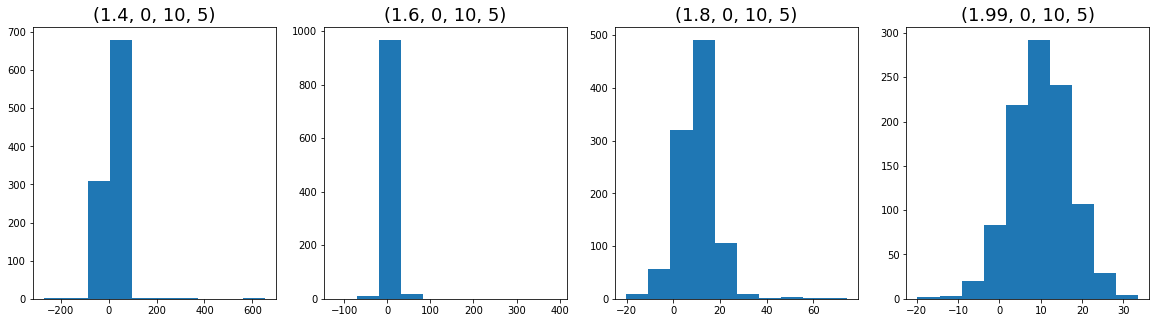

In [16]:
alphas = np.array([1.4, 1.6, 1.8, 1.99])
betas  = np.array([-0.99, -0.5, 0.5, 0.99])
mus    = np.array([-200, -100, 0, 100])
sigs   = np.array([0.1, 1, 5, 100])

beta = 0
mu = 10
sig = 5
y = stable_dist_rvs(alphas,np.repeat(beta,4),np.repeat(mu,4),\
                     np.repeat(sig,4),Ns=1000,batch_size=4)
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(y[i,:], bins=10)
    plt.title("({0:.3g}, {1:.3g}, {2:.3g}, {3:.3g})".format(alphas[i],beta,mu,sig),fontsize=18)

#### Skewness Parameter $\beta$ 
Below, we observe how histograms change with $\beta$

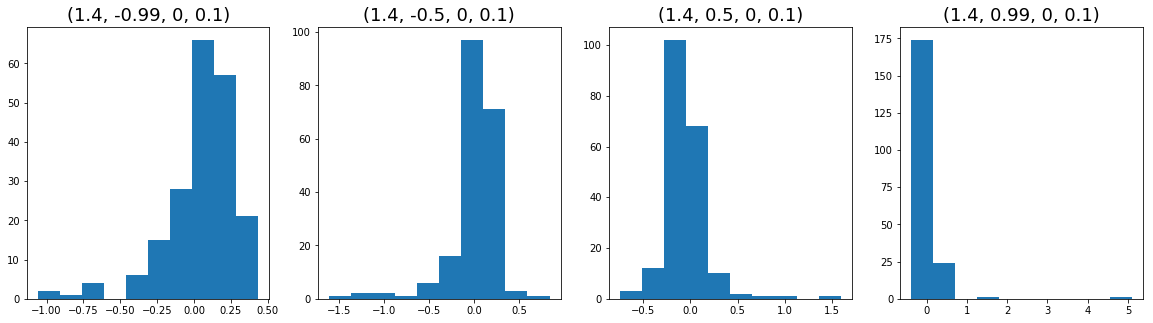

In [3]:
alpha = 1.4
mu = 0
sig = 0.1
y = stable_dist_rvs(np.repeat(alpha,4),betas,np.repeat(mu,4),np.repeat(sig,4),Ns=200,batch_size=4)
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(y[i,:])
    plt.title("({0:.3g}, {1:.3g}, {2:.3g}, {3:.3g})".format(alpha,betas[i],mu,sig),fontsize=18)
    

#### Location Parameter $\mu$
The impact of $\mu$ is rather straightforward: The mean value of the distribution changes. Observe that we set $\alpha$ to a rather high value (1.9) so that the distribution looks like Gaussian and the role of $\mu$ is therefore more evident.

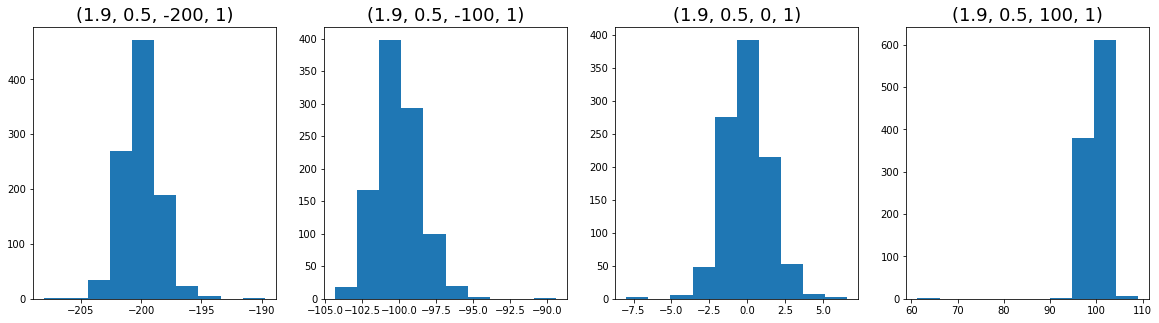

In [4]:
alpha = 1.9
beta = 0.5
sigma = 1
y = stable_dist_rvs(np.repeat(alpha,4),np.repeat(beta,4),mus,\
                     np.repeat(sigma,4),Ns=1000,batch_size=4)
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(y[i,:])
    plt.title("({0:.3g}, {1:.3g}, {2:.3g}, {3:.3g})".format(alpha,beta,mus[i],sigma),fontsize=18)

#### Scale Parameter $\sigma$
Similar to $\mu$, we are familiar with the $\sigma$ parameter from Gaussian distribution. Below, we see that playing with $\sigma$, we can control the variance of the samples.

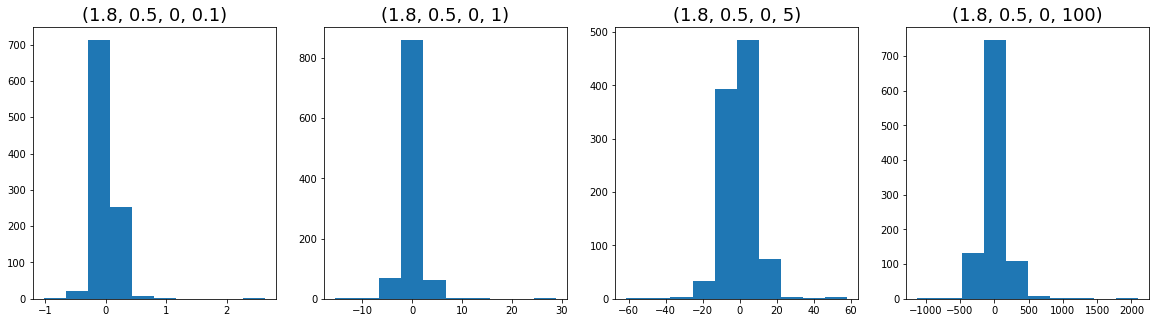

In [5]:
alpha = 1.8
beta = 0.5
mu = 0
y = stable_dist_rvs(np.repeat(alpha,4),np.repeat(beta,4),np.repeat(mu,4),sigs,Ns=1000,batch_size=4)
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(y[i,:])
    plt.title("({0:.3g}, {1:.3g}, {2:.3g}, {3:.3g})".format(alpha,beta,mu,sigs[i]),fontsize=18)

#### Sampling from Standard Normal Distribution
Now we generate data from standard Gaussian distribution by setting $\alpha=2$ and $\beta=0$.

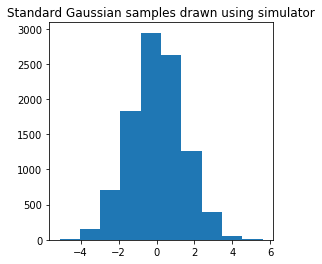

In [6]:
y = stable_dist_rvs(np.array([2]),np.array([0]),np.array([0]),np.array([1]),Ns=10000,batch_size=1)
plt.figure(figsize=(4,4))
plt.hist(y[0,:],bins=10)
plt.title('Standard Gaussian samples drawn using simulator');

## 3. Experiments

To analyze the performance of likelihood-free inference methods on this problem, we follow a similar experiment setup as presented in [2]:

 * **Data Generation:** We first generate three datasets where only stability parameter varies among the generative parameters. Note that the larger the stability parameter, the harder the estimation problem. The true parmeters used to generate the easiest data set are the same as in [2]. Each data set consists of 200 samples.
 * **Summary Statistics:** Previous methods for stable distribution parameter estimation dominantly use five summary statistic vectors, which we denote by $S_1$-$S_5$. In this work, we implement all of them and test the performance of the methods on each vector separately.
 * **Inference:** We then run rejection sampling and SMC using on summary statistic vector independently so that we can judge how informative summary vectors are. We use the same number of data points and (simulator) sample sizes as in [2]. We first try to infer all the parameters together using summary statistics vectors that are informative about all model variables, then we infer a variable at a time with appropriate summary statistics.

### 3.1. Defining the Model and Priors

Similar to [4,2], we consider a restricted domain for the priors:
 * $\alpha \sim [1.1, 2]$
 * $\beta \sim [-1, 1]$
 * $\mu \sim [-300, 300]$
 * $\sigma \sim (0, 300]$

Limiting the domains of $\mu$ and $\sigma$ is meaningful for practical purposes. We also restrict the possible values that $\alpha$ can take because summary statistics are defined for $\alpha>1$.

In [17]:
elfi.new_model()
alpha = elfi.Prior(ss.uniform, 1.1, 0.9)
beta  = elfi.Prior(ss.uniform, -1, 2)
mu    = elfi.Prior(ss.uniform, -300, 600)
sigma = elfi.Prior(ss.uniform, 0, 300)

### 3.2. Summary Statistics

In this section, we give brief explanations for 5 sets of summary statistics. Last four summary vectors are based on characteristic function of stable distribution. Thus the expressions for the summary vectors are too complex to discuss here. We give the exact formulas of the first set of summary statistics and those of the last four items below can be checked out in Section 3.1.1 of [2]. 

#### S1 - McCulloch’s Quantiles
McCulloch has developed a method for estimating the parameters based on sample quantiles [5]. He gives consistent estimators, which are the functions of sample quantiles, of population quantiles, and provides tables for recovering $\alpha$ and $\beta$ from the estimated quantiles. Note that in contrast to his work, we use the sample means as the summary for the location parameter $\mu$. If $\hat{q}_p(x)$ denotes the estimate for $p$'th quantile, then the statictics are as follows:
\begin{align}
\hat{v}_\alpha = \frac{\hat{q}_{0.95}(\cdot)-\hat{q}_{0.05}(\cdot)}{\hat{q}_{0.75}(\cdot)-\hat{q}_{0.25}(\cdot)} \qquad \hat{v}_\beta = \frac{\hat{q}_{0.95}(\cdot)+\hat{q}_{0.05}(\cdot)-2\hat{q}_{0.5}(\cdot)}{\hat{q}_{0.95}(\cdot)-\hat{q}_{0.5}(\cdot)} \qquad \hat{v}_\mu = \frac{1}{N}\sum_{i=1}^N x_i \qquad \hat{v}_\sigma = \frac{\hat{q}_{0.75}(\cdot)-\hat{q}_{0.25}(\cdot)}{\sigma}
\end{align}
where the samples are denoted by $x_i$. In practice, we observe that $\frac{1}{\sigma}$ term in $\hat{v}_\sigma$ detoriates the performance, so we ignore it. 

#### S2 - Zolotarev’s Transformation
Zolotarev gives an alternative parameterization of stable distribution in terms of its characteristic function [6]. The characteristic function of a probability density function is simply its Fourier transform and it completely defines the pdf [7]. More formally, the characteristic function of a random variable $X$ is defined to be
\begin{align}
\phi_X(t) = \mathbb{E}[e^{itX}]
\end{align}
The exact statistics are not formulated here as it would be out of scope of this project but one can see, for example [6] or [2] for details.

#### S3 - Press’ Method of Moments
By evaluating the characteristic function at particular time points, it is possible to obtain the method of moment equations [8]. In turn, these equations can be used to obtain estimates for the model parameters. We follow the recommended evaluation time points in [2].


#### S4 - Empirical Characteristic Function
The formula for empirical characteristic function is
\begin{align}
\hat{\phi}_X(t) = \frac{1}{n} \sum_{i=1}^N e^{itX_i}
\end{align}
where $X_i$ denotes the samples and $t \in (-\infty,\infty)$. So, the extracted statistics are $\left(\hat{\phi}_X(t_1),\hat{\phi}_X(t_2),\ldots,\hat{\phi}_X(t_20\right)$ and $t=\left\{ \pm 0.5, \pm 1 \ldots \pm 5 \right\}$

#### S5 - Mean, Quantiles and Kolmogorov–Smirnov Statistic
The Kolmogorov–Smirnov statistic measures the maximum absolute distance between a cumulative density function and the empirical distribution function, which is defined as a step function that jumps up by $1/n$ at each of the $n$ data points. By computing the statistic on two empricial distribution functions (rather than a cdf), one can test whether two underlying one-dimensional probability distributions differ. Observe that in ABC setting we compare the empirical distribution function of the observed data and the data generated using a set of candidate parameters. In addition to Kolmogorov–Smirnov statistic, we include the mean and a set of quantiles $\hat{q}_p(x)$ where $p \in \{0.01, 0.05, 0.1, 0.15, \ldots, 0.9, 0.95, 0.99\}$.

In [18]:
def S1(X):
    q95 = np.percentile(X,95,axis=1)
    q75 = np.percentile(X,75,axis=1)
    q50 = np.percentile(X,50,axis=1)
    q25 = np.percentile(X,25,axis=1)
    q05 = np.percentile(X,5,axis=1)
    Xalpha = (q95-q05) / (q75-q25)
    Xbeta = (q95+q05-2*q50) / (q95-q05)
    Xmu = np.mean(X,axis=1)
    Xsig = (q75-q25)
    return np.column_stack((Xalpha,Xbeta,Xmu,Xsig))

def S1_alpha(X):
    X = S1(X)
    return X[:,0]

def S1_beta(X):
    X = S1(X)
    return X[:,1]

def S1_mu(X):
    X = S1(X)
    return X[:,2]

def S1_sigma(X):
    X = S1(X)
    return X[:,3]


def S2(X):
    ksi = 0.25
    N = int(np.floor((X.shape[1]-1)/3))
    R = X.shape[0]
    Z = np.zeros((R,N))
    for i in range(N):
        Z[:,i] = X[:,3*i] - ksi*X[:,3*i+1] - (1-ksi)*X[:,3*i+2]
    V = np.log(np.abs(Z))
    U = np.sign(Z)
    sighat = np.mean(V,1)
    betahat = np.mean(U,1)
    t1 = 6/np.pi/np.pi*np.var(V,1) - 3/2*np.var(U,1)+1
    t2 = np.power(1+np.abs(betahat),2)/4
    alphahat = np.max(np.vstack((t1,t2)),0)
    muhat = np.mean(X,axis=1)
    return np.column_stack((alphahat,betahat,muhat,sighat))

def S2_alpha(X):
    X = S2(X)
    return X[:,0]

def S2_beta(X):
    X = S2(X)
    return X[:,1]

def S2_mu(X):
    X = S2(X)
    return X[:,2]

def S2_sigma(X):
    X = S2(X)
    return X[:,3]


def S3(X):
    t = [0.2, 0.8, 1, 0.4]
    pht = np.zeros((X.shape[0],len(t)))
    uhat = np.zeros((X.shape[0],len(t)))
    for i in range(len(t)):
        pht[:,i] = np.mean(np.exp(1j*t[i]*X),1)
        uhat[:,i] = np.arctan( np.sum(np.cos(t[i]*X),1) / np.sum(np.sin(t[i]*X),1) )
    alphahat = np.log(np.log(np.abs(pht[:,0]))/np.log(np.abs(pht[:,1]))) / np.log(t[0]/t[1])
    sighat = np.exp( (np.log(np.abs(t[0]))*np.log(-np.log(np.abs(pht[:,1]))) - \
                      np.log(np.abs(t[1]))*np.log(-np.log(np.abs(pht[:,0]))))/ \
                      np.log(t[0]/t[1]) )
    betahat = (uhat[:,3]/t[3]-uhat[:,2]/t[2]) / np.power(sighat,alphahat) / np.tan(alphahat*np.pi/2) \
                        / (np.power(np.abs(t[3]),alphahat-1) - np.power(np.abs(t[2]),alphahat-1) )
    muhat = (np.power(np.abs(t[3]),alphahat-1)*uhat[:,3]/t[3] - np.power(np.abs(t[2]),alphahat-1)*uhat[:,2]/t[2]) \
                        / (np.power(np.abs(t[3]),alphahat-1) - np.power(np.abs(t[2]),alphahat-1) )
    return np.column_stack((alphahat,betahat,muhat,sighat))

def S3_alpha(X):
    X = S3(X)
    return X[:,0]

def S3_beta(X):
    X = S3(X)
    return X[:,1]

def S3_mu(X):
    X = S3(X)
    return X[:,2]

def S3_sigma(X):
    X = S3(X)
    return X[:,3]


def S4(X):
    Xc = X.copy()
    Xc = Xc - np.median(Xc,1).reshape((-1,1))
    Xc = Xc / 2 / ss.iqr(Xc,1).reshape((-1,1))
    ts = np.linspace(-5,5,21)
    phts = np.zeros((Xc.shape[0],len(ts)))
    for i in range(len(ts)):
        phts[:,i] = np.mean(np.exp(1j*ts[i]*Xc),1)
    return phts


def S5(X):
    N = X.shape[0]
    R = np.zeros((N,23))
    kss = np.zeros(N).reshape((N,1))
    for i in range(N):
        R[i,0] = ss.ks_2samp(X[i,:],z.flatten()).statistic
    R[:,1] = np.mean(X,axis=1)
    qs = np.linspace(0,100,21)
    qs[0] = 1
    qs[-1] = 99
    for i in range(21):
        R[:,i+2] = np.percentile(X,qs[i],axis=1)
    return R

Below, I visualize the ELFI graph. Note that the sole purpose of the below cell is to draw the graph. Therefore, in the next cell, I re-create the initial model (and the priors).

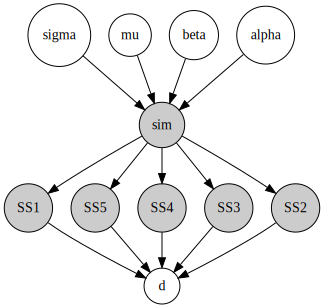

In [26]:
sim = elfi.Simulator(stable_dist_rvs,alpha,beta,mu,sigma,observed=None)
SS1 = elfi.Summary(S1, sim)
SS2 = elfi.Summary(S2, sim)
SS3 = elfi.Summary(S3, sim)
SS4 = elfi.Summary(S4, sim)
SS5 = elfi.Summary(S5, sim)
d = elfi.Distance('euclidean',SS1,SS2,SS3,SS4,SS5)
elfi.draw(d)

In [27]:
elfi.new_model()
alpha = elfi.Prior(ss.uniform, 1.1, 0.9)
beta  = elfi.Prior(ss.uniform, -1, 2)
mu    = elfi.Prior(ss.uniform, -300, 600)
sigma = elfi.Prior(ss.uniform, 0, 300)

### 3.3. Data Sets

Below, the data sets are visualized. In each data set we set $\beta=0.3$, $\mu=10$ and $\sigma=10$. $\alpha$ is set to be 1.7/1.2/0.7 in easy/medium/hard data sets. As we see, increased $\alpha$ values lead to more scattered samples.

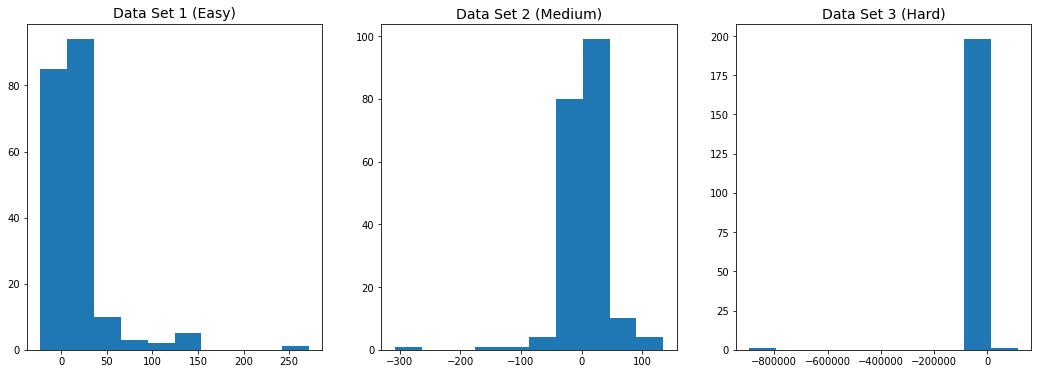

In [9]:
Ns = 200
alpha0 = np.array([1.7,1.2,0.7])
beta0  = np.array([0.9,0.3,0.3])
mu0    = np.array([10,10,10])
sig0   = np.array([10,10,10])
y0 = stable_dist_rvs(alpha0,beta0,mu0,sig0,Ns,batch_size=3)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.hist(y0[0,:])
plt.title('Data Set 1 (Easy)', fontsize=14)
plt.subplot(1,3,2)
plt.hist(y0[1,:])
plt.title('Data Set 2 (Medium)', fontsize=14)
plt.subplot(1,3,3)
plt.hist(y0[2,:])
plt.title('Data Set 3 (Hard)', fontsize=14);

z = y0[0,:].reshape((1,-1))

### 3.4. Running the Experiments

In [20]:
class Experiment():
    def __init__(self, inf_method, dataset, sumstats, quantile=None, schedule=None, Nsamp=100):
        '''
        inf_method - 'SMC' or 'Rejection'
        dataset    - 'Easy', 'Medium' or 'Hard'
        sumstats   - 'S1', 'S2', 'S3', 'S4' or 'S5'
        '''
        self.inf_method = inf_method
        self.dataset = dataset
        self.sumstats = sumstats
        self.quantile = quantile
        self.schedule = schedule
        self.Nsamp = Nsamp
        self.res = None
        
    def infer(self):
        # read the dataset
        if self.dataset == 'Easy':
            z = y0[0,:].reshape((1,-1))
        elif self.dataset == 'Medium':
            z = y0[1,:].reshape((1,-1))
        elif self.dataset == 'Hard':
            z = y0[2,:].reshape((1,-1))
        sim = elfi.Simulator(stable_dist_rvs,alpha,beta,mu,sigma,observed=z)
        
        ss_func = globals().get(self.sumstats)
        SS = elfi.Summary(ss_func, sim)
        d = elfi.Distance('euclidean',SS)

        # run the inference and save the results
        if self.inf_method == 'SMC':
            algo = elfi.SMC(d, batch_size=Ns)
            self.res = algo.sample(self.Nsamp, self.schedule)
        elif self.inf_method == 'Rejection':
            algo = elfi.Rejection(d, batch_size=Ns)
            self.res = algo.sample(self.Nsamp, quantile=self.quantile)

#### Inferring Model Parameters Altogether

In this method, we use summary statistics to infer all the model parameters. This is the natural way of doing ABC inference as long as the summary statistics are informative about all parameters. 

In [ ]:
datasets = ['Easy','Medium','Hard']
sumstats = ['S1','S2','S3','S4','S5']
inferences = ['Rejection','SMC']

exps_alt = []
for dataset in datasets:
    for sumstat in sumstats:
        rej = Experiment('Rejection',dataset,sumstat,quantile=0.01,Nsamp=1000)
        rej.infer()
        exps_alt.append(rej)
        schedule = [rej.res.threshold*4, rej.res.threshold*2, rej.res.threshold]
        smc = Experiment('SMC',dataset,sumstat,schedule=schedule,Nsamp=1000)
        smc.infer()
        exps_alt.append(smc)

#### Inferring Model Parameters Separately

Now, we try to infer each model parameter separately. This way of inference applies to the first three summary statictics. More concretely, our summary statistics will be not vectors but just some real numbers which are informative about only a single parameter. Note that we repeat the procedure for all four parameters.

In [ ]:
params = ['alpha','beta','mu','sigma']
exps_sep = []
for dataset in datasets:
    for sumstat in sumstats[0:3]:
        for param in params:
            sumstat_ = sumstat + '_' + param
            rej = Experiment('Rejection',dataset,sumstat_,quantile=0.01,Nsamp=250)
            rej.infer()
            exps_sep.append(rej)
            schedule = [rej.res.threshold*4, rej.res.threshold*2, rej.res.threshold]
            smc = Experiment('SMC',dataset,sumstat_,schedule=schedule,Nsamp=250)
            smc.infer()
            exps_sep.append(smc)
            
file_pi = open('exps_sep.obj', 'wb')
pickle.dump(exps_sep, file_pi)

## 4. Results

In [27]:
from IPython.display import display, Markdown, Latex

def print_results_alt(dataset,inference,exps_):
    nums = []
    for sumstat in sumstats:
        exp_ = [e for e in exps_ if e.sumstats==sumstat][0]
        for param in params:
            nums.append(np.mean(exp_.res.outputs[param]))
            nums.append(np.std(exp_.res.outputs[param]))
    if dataset == 'Easy':
        ds_id = 0
    elif dataset == 'Medium':
        ds_id = 1
    elif dataset == 'Hard':
        ds_id = 2
    tmp = '### {0:s} Data Set - {1:s}'.format(dataset,inference)
    display(Markdown(tmp))
    tmp = "| Variable | True Value | S1  | S2   | S3   | S4   | S5   | \n \
    |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| \n \
    | {44:s}   | {40:4.2f}  | {0:4.2f} $\pm$ {1:4.2f} | {8:4.2f} $\pm$ {9:4.2f}    | {16:4.2f} $\pm$ {17:4.2f} | {24:4.2f} $\pm$ {25:4.2f} | {32:4.2f} $\pm$ {33:4.2f}  | \n \
    | {45:s}   | {41:4.2f}  | {2:4.2f} $\pm$ {3:4.2f} | {10:4.2f} $\pm$ {11:4.2f}  | {18:4.2f} $\pm$ {19:4.2f} | {26:4.2f} $\pm$ {27:4.2f} | {34:4.2f} $\pm$ {35:4.2f}  | \n \
    | $\mu$    | {42:4.2f}  | {4:4.2f} $\pm$ {5:4.2f} | {12:4.2f} $\pm$ {13:4.2f}  | {20:4.2f} $\pm$ {21:4.2f} | {28:4.2f} $\pm$ {29:4.2f} | {36:4.2f} $\pm$ {37:4.2f}  | \n \
    | $\gamma$ | {43:4.2f}  | {6:4.2f} $\pm$ {7:4.2f} | {14:4.2f} $\pm$ {15:4.2f}  | {22:4.2f} $\pm$ {23:4.2f} | {30:4.2f} $\pm$ {31:4.2f} | {38:4.2f} $\pm$ {39:4.2f}  |".format(\
    nums[0],nums[1],nums[2],nums[3],nums[4],nums[5],nums[6],nums[7],nums[8],nums[9], \
    nums[10],nums[11],nums[12],nums[13],nums[14],nums[15],nums[16],nums[17],nums[18],nums[19], \
    nums[20],nums[21],nums[22],nums[23],nums[24],nums[25],nums[26],nums[27],nums[28],nums[29], \
    nums[30],nums[31],nums[32],nums[33],nums[34],nums[35],nums[36],nums[37],nums[38],nums[39], \
    alpha0[ds_id],beta0[ds_id],mu0[ds_id],sig0[ds_id],r'$\alpha$',r'$\beta$')
    display(Markdown(tmp))
    
    
def print_results_sep(dataset,inference,exps_):
    nums = []
    for sumstat in sumstats[0:3]:
        for param in params:
            exp_ = [e for e in exps_ if str(e.sumstats)==str(sumstat)+'_'+param][0]
            nums.append(np.mean(exp_.res.outputs[param]))
            nums.append(np.std(exp_.res.outputs[param]))  
    if dataset == 'Easy':
        ds_id = 0
    elif dataset == 'Medium':
        ds_id = 1
    elif dataset == 'Hard':
        ds_id = 2
    tmp = '### {0:s} Data Set - {1:s}'.format(dataset,inference)
    display(Markdown(tmp))
    tmp = "| Variable | True Value | S1  | S2   | S3 | \n \
    |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| \n \
    | {28:s}   | {24:4.2f}  | {0:4.2f} $\pm$ {1:4.2f} | {8:4.2f} $\pm$ {9:4.2f}    | {16:4.2f} $\pm$ {17:4.2f} | \n \
    | {29:s}   | {25:4.2f}  | {2:4.2f} $\pm$ {3:4.2f} | {10:4.2f} $\pm$ {11:4.2f}  | {18:4.2f} $\pm$ {19:4.2f} | \n \
    | $\mu$    | {26:4.2f}  | {4:4.2f} $\pm$ {5:4.2f} | {12:4.2f} $\pm$ {13:4.2f}  | {20:4.2f} $\pm$ {21:4.2f} | \n \
    | $\gamma$ | {27:4.2f}  | {6:4.2f} $\pm$ {7:4.2f} | {14:4.2f} $\pm$ {15:4.2f}  | {22:4.2f} $\pm$ {23:4.2f} |".format(\
    nums[0],nums[1],nums[2],nums[3],nums[4],nums[5],nums[6],nums[7],nums[8],nums[9], \
    nums[10],nums[11],nums[12],nums[13],nums[14],nums[15],nums[16],nums[17],nums[18],nums[19], \
    nums[20],nums[21],nums[22],nums[23], \
    alpha0[ds_id],beta0[ds_id],mu0[ds_id],sig0[ds_id],r'$\alpha$',r'$\beta$')
    display(Markdown(tmp))

### 4.1. When Parameters Inferred Altogether

In [28]:
for inference in inferences:
    for dataset in datasets:
        results = [e for e in exps_alt if e.inf_method==inference and e.dataset==dataset]
        print_results_alt(dataset,inference,results)

### Easy Data Set - Rejection

| Variable | True Value | S1  | S2   | S3   | S4   | S5   | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 1.70  | 1.55 $\pm$ 0.26 | 1.57 $\pm$ 0.26    | 1.52 $\pm$ 0.25 | 1.42 $\pm$ 0.12 | 1.70 $\pm$ 0.22  | 
     | $\beta$   | 0.90  | 0.06 $\pm$ 0.57 | -0.01 $\pm$ 0.56  | 0.03 $\pm$ 0.57 | -0.10 $\pm$ 0.58 | 0.04 $\pm$ 0.57  | 
     | $\mu$    | 10.00  | 18.10 $\pm$ 25.19 | 3.03 $\pm$ 66.03  | 8.19 $\pm$ 166.82 | 20.53 $\pm$ 164.65 | 15.89 $\pm$ 21.25  | 
     | $\gamma$ | 10.00  | 11.14 $\pm$ 6.97 | 131.18 $\pm$ 81.86  | 154.36 $\pm$ 80.53 | 156.88 $\pm$ 96.64 | 15.40 $\pm$ 10.35  |

### Medium Data Set - Rejection

| Variable | True Value | S1  | S2   | S3   | S4   | S5   | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 1.20  | 1.55 $\pm$ 0.25 | 1.60 $\pm$ 0.25    | 1.57 $\pm$ 0.25 | 1.24 $\pm$ 0.09 | 1.64 $\pm$ 0.25  | 
     | $\beta$   | 0.30  | 0.04 $\pm$ 0.57 | 0.11 $\pm$ 0.56  | -0.10 $\pm$ 0.63 | -0.00 $\pm$ 0.66 | 0.06 $\pm$ 0.58  | 
     | $\mu$    | 10.00  | 4.73 $\pm$ 20.91 | 6.99 $\pm$ 59.83  | -48.05 $\pm$ 167.52 | -19.89 $\pm$ 179.68 | 6.63 $\pm$ 21.01  | 
     | $\gamma$ | 10.00  | 12.64 $\pm$ 7.88 | 130.31 $\pm$ 80.42  | 164.39 $\pm$ 83.43 | 149.95 $\pm$ 83.80 | 17.04 $\pm$ 10.77  |

### Hard Data Set - Rejection

| Variable | True Value | S1  | S2   | S3   | S4   | S5   | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 0.70  | 1.21 $\pm$ 0.12 | 1.21 $\pm$ 0.13    | 1.60 $\pm$ 0.25 | 1.16 $\pm$ 0.05 | 1.20 $\pm$ 0.08  | 
     | $\beta$   | 0.30  | 0.11 $\pm$ 0.64 | -0.00 $\pm$ 0.65  | -0.03 $\pm$ 0.57 | 0.03 $\pm$ 0.29 | -0.52 $\pm$ 0.34  | 
     | $\mu$    | 10.00  | -109.26 $\pm$ 165.99 | -72.97 $\pm$ 160.93  | -22.80 $\pm$ 166.88 | -10.55 $\pm$ 185.99 | -2.12 $\pm$ 163.55  | 
     | $\gamma$ | 10.00  | 219.33 $\pm$ 58.19 | 214.20 $\pm$ 63.70  | 108.77 $\pm$ 93.89 | 130.86 $\pm$ 85.44 | 235.16 $\pm$ 50.60  |

### Easy Data Set - SMC

| Variable | True Value | S1  | S2   | S3   | S4   | S5   | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 1.70  | 1.63 $\pm$ 0.23 | 1.61 $\pm$ 0.22    | 1.56 $\pm$ 0.25 | 1.45 $\pm$ 0.12 | 1.66 $\pm$ 0.23  | 
     | $\beta$   | 0.90  | -0.03 $\pm$ 0.51 | -0.01 $\pm$ 0.56  | 0.00 $\pm$ 0.48 | 0.06 $\pm$ 0.53 | 0.08 $\pm$ 0.53  | 
     | $\mu$    | 10.00  | 18.88 $\pm$ 18.72 | 13.26 $\pm$ 28.46  | 38.88 $\pm$ 153.68 | -15.50 $\pm$ 163.45 | 13.42 $\pm$ 17.15  | 
     | $\gamma$ | 10.00  | 14.47 $\pm$ 6.90 | 116.80 $\pm$ 75.98  | 138.74 $\pm$ 75.04 | 156.53 $\pm$ 79.37 | 16.56 $\pm$ 9.92  |

### Medium Data Set - SMC

| Variable | True Value | S1  | S2   | S3   | S4   | S5   | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 1.20  | 1.59 $\pm$ 0.24 | 1.60 $\pm$ 0.25    | 1.55 $\pm$ 0.24 | 1.23 $\pm$ 0.08 | 1.69 $\pm$ 0.19  | 
     | $\beta$   | 0.30  | -0.02 $\pm$ 0.55 | -0.03 $\pm$ 0.54  | 0.08 $\pm$ 0.55 | -0.06 $\pm$ 0.60 | 0.02 $\pm$ 0.50  | 
     | $\mu$    | 10.00  | 6.33 $\pm$ 20.79 | 1.17 $\pm$ 35.90  | -24.07 $\pm$ 167.63 | -7.87 $\pm$ 146.01 | 4.12 $\pm$ 16.56  | 
     | $\gamma$ | 10.00  | 13.26 $\pm$ 7.99 | 119.80 $\pm$ 69.73  | 153.43 $\pm$ 74.23 | 145.02 $\pm$ 74.18 | 18.70 $\pm$ 10.50  |

### Hard Data Set - SMC

| Variable | True Value | S1  | S2   | S3   | S4   | S5   | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 0.70  | 1.20 $\pm$ 0.10 | 1.21 $\pm$ 0.12    | 1.55 $\pm$ 0.25 | 1.17 $\pm$ 0.06 | 1.23 $\pm$ 0.10  | 
     | $\beta$   | 0.30  | 0.16 $\pm$ 0.57 | 0.08 $\pm$ 0.60  | 0.01 $\pm$ 0.54 | -0.00 $\pm$ 0.27 | -0.49 $\pm$ 0.37  | 
     | $\mu$    | 10.00  | -149.47 $\pm$ 129.44 | -145.44 $\pm$ 98.83  | 18.84 $\pm$ 160.01 | -14.26 $\pm$ 160.55 | -8.27 $\pm$ 158.52  | 
     | $\gamma$ | 10.00  | 213.38 $\pm$ 60.33 | 204.80 $\pm$ 65.50  | 132.00 $\pm$ 89.64 | 164.00 $\pm$ 77.94 | 230.60 $\pm$ 41.99  |

The tables may not show the performance clearly. Thus, we plot the marginals of 5 summary vectors when rejection sampling is executed on the easy data set. As can be seen, only $\mu$ is identified well. S1 estimates a somewhat good interval for $\sigma$. All the other plots are almost random draws from the prior.

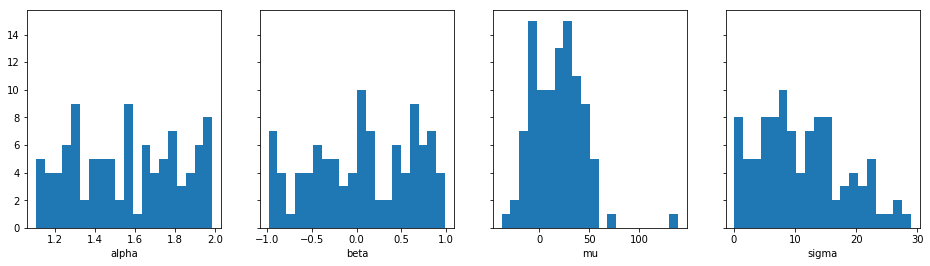

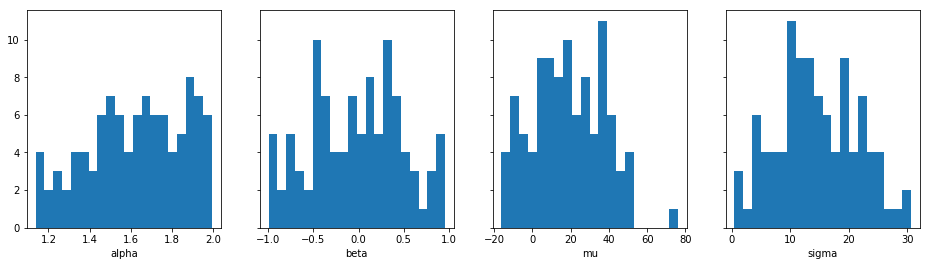

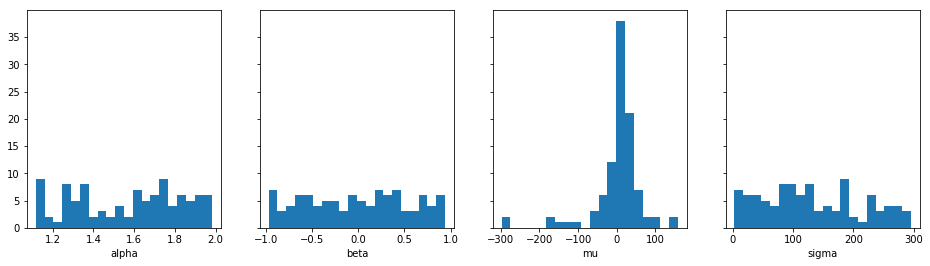

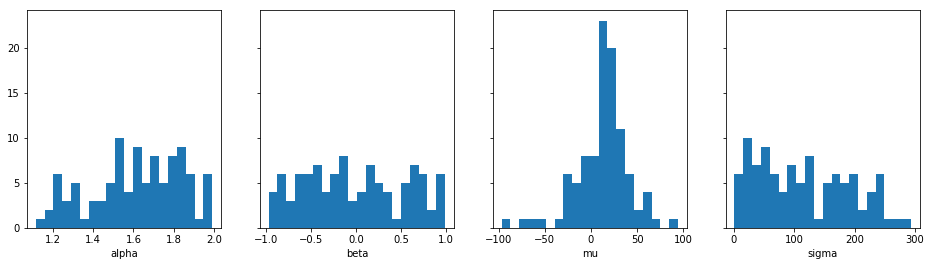

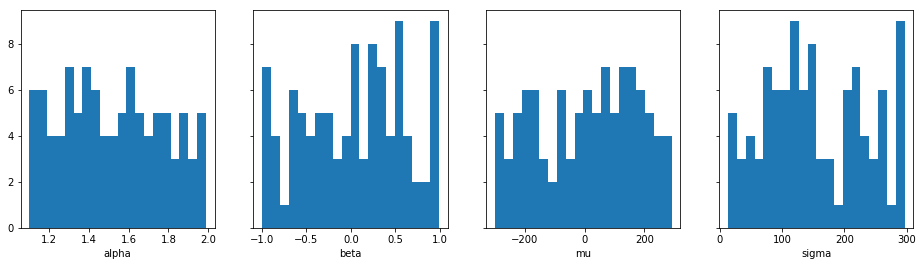

In [29]:
exps_alt[0].res.plot_marginals();
exps_alt[1].res.plot_marginals();
exps_alt[2].res.plot_marginals();
exps_alt[3].res.plot_marginals();
exps_alt[4].res.plot_marginals();

### 4.2. When Parameters Inferred Separately

In [35]:
for inference in inferences[0:1]:
    for dataset in datasets:
        results = [e for e in exps_sep if e.inf_method==inference and e.dataset==dataset]
        print_results_sep(dataset,inference,results)

### Easy Data Set - Rejection

| Variable | True Value | S1  | S2   | S3 | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 1.70  | 1.25 $\pm$ 0.11 | 1.68 $\pm$ 0.22    | 1.54 $\pm$ 0.28 | 
     | $\beta$   | 0.90  | 0.71 $\pm$ 0.20 | -0.26 $\pm$ 0.54  | 0.02 $\pm$ 0.58 | 
     | $\mu$    | 10.00  | 24.30 $\pm$ 72.66 | 27.25 $\pm$ 63.20  | -18.46 $\pm$ 169.35 | 
     | $\gamma$ | 10.00  | 9.72 $\pm$ 1.03 | 11.20 $\pm$ 2.51  | 157.88 $\pm$ 85.18 |

### Medium Data Set - Rejection

| Variable | True Value | S1  | S2   | S3 | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 1.20  | 1.29 $\pm$ 0.12 | 1.44 $\pm$ 0.24    | 1.55 $\pm$ 0.25 | 
     | $\beta$   | 0.30  | 0.67 $\pm$ 0.21 | -0.05 $\pm$ 0.59  | -0.03 $\pm$ 0.59 | 
     | $\mu$    | 10.00  | 8.77 $\pm$ 75.53 | 7.05 $\pm$ 67.09  | -6.00 $\pm$ 164.87 | 
     | $\gamma$ | 10.00  | 10.29 $\pm$ 1.34 | 11.19 $\pm$ 2.25  | 148.12 $\pm$ 85.94 |

### Hard Data Set - Rejection

| Variable | True Value | S1  | S2   | S3 | 
     |:-----:   | :----------: |:-------------:|:-----:|:-----:|:-----:|:-----:| 
     | $\alpha$   | 0.70  | 1.16 $\pm$ 0.05 | 1.28 $\pm$ 0.18    | 1.56 $\pm$ 0.26 | 
     | $\beta$   | 0.30  | 0.38 $\pm$ 0.34 | -0.02 $\pm$ 0.56  | -0.02 $\pm$ 0.59 | 
     | $\mu$    | 10.00  | -93.14 $\pm$ 162.97 | -107.49 $\pm$ 149.42  | -9.16 $\pm$ 170.94 | 
     | $\gamma$ | 10.00  | 12.59 $\pm$ 1.55 | 40.17 $\pm$ 8.18  | 136.03 $\pm$ 86.72 |

Now we take a look at the marginals for S1 only (Note that due to the design of the inference, the output of each experiment is the marginals of a single variable). Below are the marginals of the first 4 experiment, which correspond to $\alpha, \beta, \mu$ and $\sigma$ variables. True values of the parameters are given in paranthesis.

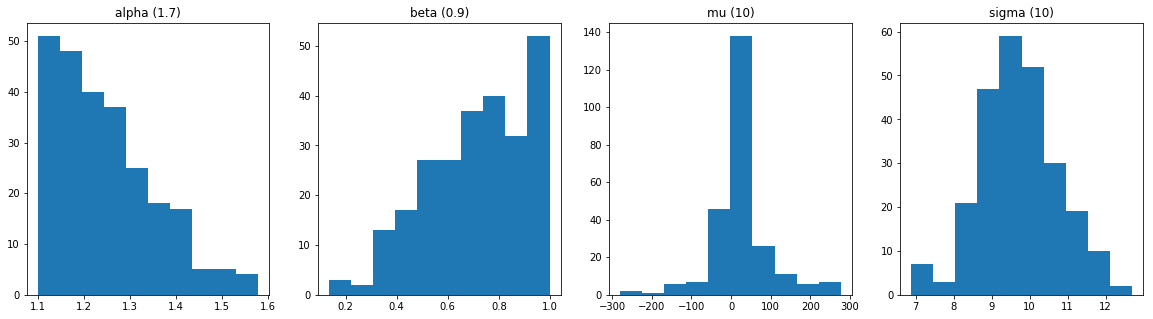

In [36]:
alphas = exps_sep[0].res.samples['alpha']
betas = exps_sep[2].res.samples['beta']
mus = exps_sep[4].res.samples['mu']
sigmas = exps_sep[6].res.samples['sigma']

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.hist(alphas)
plt.title('alpha (1.7)')
plt.subplot(142)
plt.hist(betas)
plt.title('beta (0.9)')
plt.subplot(143)
plt.hist(mus)
plt.title('mu (10)')
plt.subplot(144)
plt.hist(sigmas)
plt.title('sigma (10)');

 - Unsurprisingly, the easier the data set is, the better the results are. The easiness of the data set is basically controlled by the spread of the data. So, we can conclude that if the samples are concentrated in a region, which happens when $\alpha$ is large, the estimation task gets easier.
 
 - Overall, we see that the estimates are much better when we infer them separately. A possible explanation could be the curse of dimensionality: It may be easier to make four searches in 1D rather than one search in 4D. 
 
 - The best summary statistics seem to be S1 (quantiles), which have been used in this problem for centuries. When inferred separately with S1, the estimates are arguably good enough (and can always be better if we reduce the threshold). The only peculiarity is with $\alpha$, for which I have no good explanation. Nonetheless, I re-run the same experiments (with different data sets), and realized that $\alpha$ estimates are usually much better than that. Again, I am not fully able to understand why, but could be just the nature of the problem or the amount of data.


### References

[1] https://en.wikipedia.org/wiki/Stable_distribution

[2] Peters, Gareth W., Scott A. Sisson, and Yanan Fan. "Likelihood-free Bayesian inference for α-stable models." Computational Statistics & Data Analysis 56.11 (2012): 3743-3756.

[3] Yang, Yiyang. "Simulate α-Stable Random Variable and Estimate Stable Parameters Based on Market Data." (2012).

[4] Buckle, D. J. "Bayesian inference for stable distributions." Journal of the American Statistical Association 90.430 (1995): 605-613.

[5] McCulloch, J. Huston. "Simple consistent estimators of stable distribution parameters." Communications in Statistics-Simulation and Computation 15.4 (1986): 1109-1136.

[6] Zolotarev, Vladimir M. One-dimensional stable distributions. Vol. 65. American Mathematical Soc., 1986.

[7] https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)

[8] Press, S. James. "Estimation in univariate and multivariate stable distributions." Journal of the American Statistical Association 67.340 (1972): 842-846.
